            Date         Open         High          Low        Close  \
0     1994-01-03   774.109985   777.289978   768.409973   770.760010   
1     1994-01-04   771.429993   774.780029   771.020020   774.280029   
2     1994-01-05   775.229980   778.210022   773.690002   778.049988   
3     1994-01-06   780.359985   781.210022   778.250000   780.409973   
4     1994-01-07   779.289978   783.390015   778.200012   782.940002   
...          ...          ...          ...          ...          ...   
1558  2000-03-06  4935.649902  4980.149902  4887.879883  4904.850098   
1559  2000-03-07  4991.970215  5006.779785  4829.879883  4847.839844   
1560  2000-03-08  4920.859863  4923.140137  4722.140137  4897.259766   
1561  2000-03-09  4913.080078  5047.959961  4857.569824  5046.859863   
1562  2000-03-10  5060.339844  5132.520020  5039.350098  5048.620117   

        Adj Close      Volume  
0      770.760010   253020000  
1      774.280029   298600000  
2      778.049988   349880000  
3      

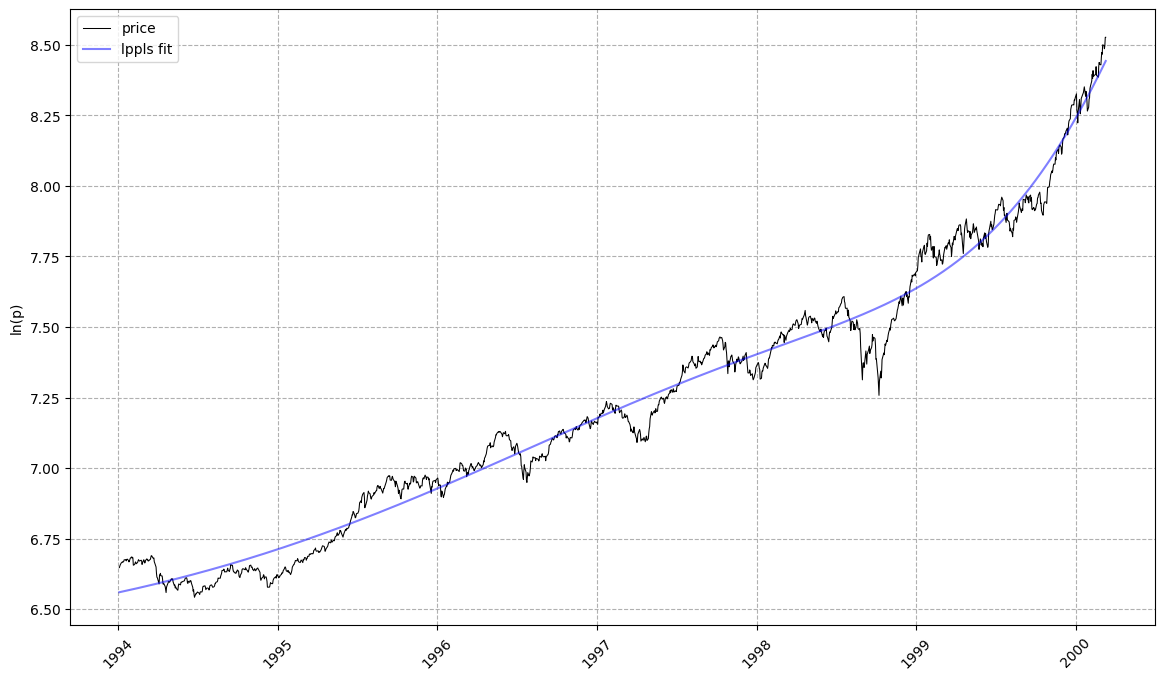

In [6]:
from lppls import lppls, data_loader
import numpy as np
import pandas as pd
from datetime import datetime as dt
%matplotlib inline

# read example dataset into df 
data = data_loader.nasdaq_dotcom()
print(data)
# convert time to ordinal
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in data['Date']]

# create list of observation data
price = np.log(data['Adj Close'].values)

# create observations array (expected format for LPPLS observations)
observations = np.array([time, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 2

# instantiate a new LPPLS model with the Nasdaq Dot-com bubble dataset
lppls_model = lppls.LPPLS(observations=observations)

# fit the model to the data and get back the params
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

# visualize the fit
lppls_model.plot_fit()


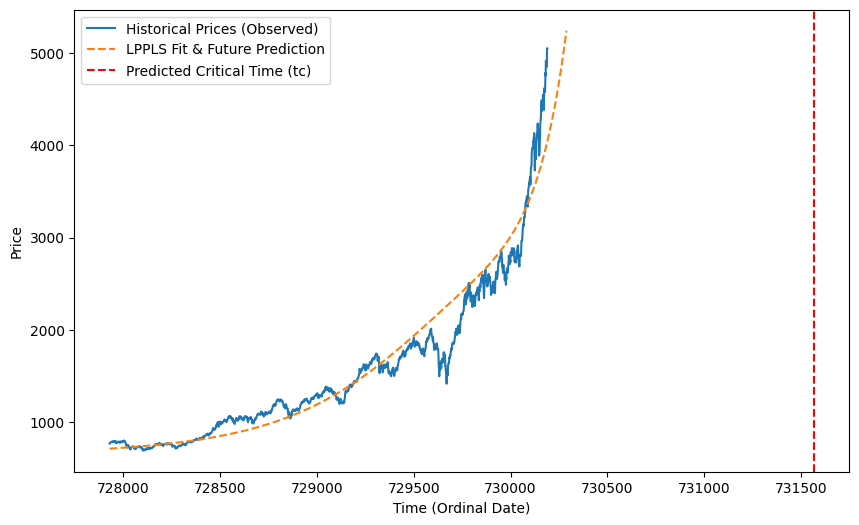

In [7]:
import matplotlib.pyplot as plt

# Extend the time array to include future points (e.g., predicting 100 future days)
future_days = 100
last_time_point = time[-1]
future_time = np.arange(last_time_point, last_time_point + future_days)

# Combine past and future time arrays
extended_time = np.concatenate([time, future_time])

# LPPLS equation for price
def lppls_price(t, tc, m, w, a, b, c):
    return a + b * (tc - t)**m + c * (tc - t)**m * np.cos(w * np.log(tc - t))

# Predict prices for both historical and future points
extended_price = lppls_price(extended_time, tc, m, w, a, b, c)

# Convert back from log prices to normal prices (undo the log transformation)
extended_price_exp = np.exp(extended_price)

# Plot the original data and the predicted future course
plt.figure(figsize=(10, 6))
plt.plot(time, np.exp(price), label="Historical Prices (Observed)")
plt.plot(extended_time, extended_price_exp, label="LPPLS Fit & Future Prediction", linestyle='--')
plt.axvline(x=tc, color='r', linestyle='--', label="Predicted Critical Time (tc)")
plt.xlabel("Time (Ordinal Date)")
plt.ylabel("Price")
plt.legend()
plt.show()
